<a href="https://colab.research.google.com/github/GokayToga/VRCM.Net/blob/main/VRCMNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VRCM.Net**

Virtual Reality Cybersickness Mitigation&Prediction Net, this project is my research project on Exploration of Prediction and Reducement Techniques on Cybersickness in VR Technologies using Machine Learning and Deep Learning

In [ ]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Masking, TimeDistributed

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
!pip install keras-tcn

In [ ]:
import keras_tuner as kt


## CNN‐RNN Hybrid

### 1D CNN Front-End + GRU Back-End **(Chosen Model Architecture)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, BatchNormalization, Dropout,
    Bidirectional, GRU, MultiHeadAttention, Add, LayerNormalization,
    TimeDistributed, Dense, Concatenate, Lambda, GRUCell
)
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, BatchNormalization, Dropout,
    Bidirectional, GRU, MultiHeadAttention, Add, LayerNormalization,
    TimeDistributed, Dense, Concatenate, Lambda, GRUCell
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Added Adam optimizer
from tensorflow.keras import backend as K
from tcn import TCN

For our small dataset

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the CSV file (make sure the file path is correct)
df = pd.read_csv("DATA_score&eye_with_sessions.csv")

# Ensure the data is sorted by Session and then by Count (time order)
df = df.sort_values(by=['Session', 'Count'])

# Define the feature columns and target column
feature_cols = ['y_coordinate', 'blink_count', 'avg_Left_Pupil', 'fixation_count', 'x_coordinate']
target_col = 'comfortLevel'

# Group the data by session and extract sequences
session_features = []
session_targets = []
session_lengths = []  # to keep track of actual sequence lengths

for sess, group in df.groupby("Session"):
    group_sorted = group.sort_values(by='Count')
    X_session = group_sorted[feature_cols].values  # shape: (timesteps, num_features)
    y_session = group_sorted[target_col].values      # shape: (timesteps,)
    session_features.append(X_session)
    session_targets.append(y_session)
    session_lengths.append(len(y_session))

print("Total sessions found:", len(session_features))

# Decide on a maximum sequence length. You can use the maximum actual length or a fixed length.
max_sequence_length = max(session_lengths)  # or set a fixed value if you want truncation (e.g., 60)

# Pad the feature sequences. Padded values default to 0.0.
X_padded = pad_sequences(session_features, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Pad the target sequences similarly.
y_padded = pad_sequences(session_targets, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
# For many-to-many regression, expand dims so that y has shape (num_sessions, timesteps, 1)
y_padded = np.expand_dims(y_padded, axis=-1)

print("X_padded shape:", X_padded.shape)  # (num_sessions, max_sequence_length, num_features)
print("y_padded shape:", y_padded.shape)  # (num_sessions, max_sequence_length, 1)

# Create a sample weight array that is 1.0 for real timesteps and 0.0 for padded ones.
# We assume that in your original data, comfortLevel is never 0 (so 0 indicates padding).
sample_weights = []
for seq in session_targets:
    weight_seq = np.ones(len(seq), dtype=np.float32)
    # Pad the weights to max_sequence_length with 0's
    padded_weights = np.pad(weight_seq, (0, max_sequence_length - len(seq)), mode='constant', constant_values=0)
    sample_weights.append(padded_weights)
sample_weights = np.array(sample_weights)  # shape: (num_sessions, max_sequence_length)

# Optionally, if you want sample_weights to have an extra dimension for TimeDistributed layers:
sample_weights = np.expand_dims(sample_weights, axis=-1)
print("Sample weights shape:", sample_weights.shape)


Total sessions found: 30
X_padded shape: (30, 76, 5)
y_padded shape: (30, 76, 1)
Sample weights shape: (30, 76, 1)


For VRWalking

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1) Load data
df = pd.read_csv("all_data_reac_time.csv")

# 2) Select eye-tracking columns (as before)
eye_cols = [ 'GazeTarget_X',	'GazeTarget_Y',	'GazeTarget_Z',	'EyeFrames',	'ViveTiming',
            'Combine_Origin_X',	'Combine_Origin_Y',	'Combine_Origin_Z',	'Combine_GazeDir_X',
             'Combine_GazeDir_Y',	'Combine_GazeDir_Z',	'Combine_Validity',	'Left_Origin_X',	'Left_Origin_Y',
             'Left_Origin_Z',	'Left_GazeDir_X',	'Left_GazeDir_Y',	'Left_GazeDir_Z',	'Left_PupilSensor_X',
             'Left_PupilSensor_Y',	'Left_Diameter',	'Left_Openness',	'Left_Validity',	'Right_Origin_X',	'Right_Origin_Y',
             'Right_Origin_Z',	'Right_GazeDir_X',	'Right_GazeDir_Y',	'Right_GazeDir_Z',	'Right_PupilSensor_X',	'Right_PupilSensor_Y',
             'Right_Diameter',	'Right_Openness',	'Right_Validity',
             'Left_GazePoint_X',	'Left_GazePoint_Y',	'Left_GazePoint_Z',
             'Right_GazePoint_X',	'Right_GazePoint_Y',	'Right_GazePoint_Z',
             'Combine_GazePoint_X',	'Combine_GazePoint_Y',	'Combine_GazePoint_Z']  # your list of  eye feature names
X_all = df[eye_cols].astype('float32').values
y_all = df['fms'].astype('float32').values  # 1–10 target

# 3) Standardize features
scaler = StandardScaler().fit(X_all)
X_all = scaler.transform(X_all)

# 4) Build sliding windows
T      = 76   # window length
stride = 1    # for maximum samples; set to T for non-overlap
X_windows = []
y_windows = []

for start in range(0, len(X_all) - T + 1, stride):
    X_windows.append(X_all[start:start+T])
    y_windows.append(y_all[start:start+T])

# Handle the tail (pad to full T)
remainder = len(X_all) % stride
if remainder:
    last_X = X_all[-T:]
    last_y = y_all[-T:]
    X_windows.append(last_X)
    y_windows.append(last_y)

X = np.stack(X_windows)              # (num_windows, T, D)
y = np.expand_dims(np.stack(y_windows), -1)  # (num_windows, T, 1)

# 5) Sample‐weight mask (all real data → ones)
sw = np.ones_like(y[..., 0])         # (num_windows, T)


In [ ]:
# Grab the per-feature mean and scale (std)
means = scaler.mean_        # shape (D,)
stds  = scaler.scale_       # shape (D,)

print("means =", means.tolist())
print("stds  =", stds.tolist())

means = [-0.9599999785423279, 145.17105466078613, -1.1799999475479126, 86012.56717202323, 107389586023.15715, -1.5144499729956373, 3.0676985771047125, -33.77260362132497, -0.12469395974797108, -0.19859260688947555, 0.7372114125267665, 0.8810714666343951, 33.83678749480418, 2.9952393289535784, -38.16460709224145, -0.02955883488639349, -0.07363680626257002, 0.8425242632169795, 0.4189072690664694, 0.4923721349472197, 3.2590503800683064, 0.8286213970189086, 0.8675373998964676, -30.745663300014677, 3.617142605277788, -38.22387535941033, 0.013018625599623595, -0.07462939994445598, 0.8209679339596256, 0.4086068297472978, 0.4697177046577941, 3.1049156118782855, 0.8505785546433846, 0.8440505580502282, -0.5311064594377729, 147.79512571751007, -0.4509782691178976, -0.46418822909270635, 147.798079401707, -0.45114569395797466, -0.48406918757752443, 147.57676935286395, -0.45552767607315986]
stds  = [1.0, 91.45791052861644, 1.0, 35039.012560321906, 323139370794.91626, 12.057302359336894, 3.6472470261

In [ ]:
from sklearn.model_selection import train_test_split

# 0) Inspect sw’s shape
print("sw.shape:", sw.shape)

# 1) Flatten sample‐weight dim if needed
if sw.ndim == 3 and sw.shape[-1] == 1:
    sw_flat = sw.squeeze(-1)     # → (N, T)
elif sw.ndim == 2:
    sw_flat = sw                # already (N, T)
else:
    raise ValueError(f"Unexpected sw shape {sw.shape}")

# 2) Perform an 80/20 train/test split
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sw_flat,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 3) (Optional) further split train→train+val
X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(
    X_train, y_train, sw_train,
    test_size=0.1,        # 10% of the 80% → 8% total
    random_state=42,
    shuffle=True
)

# 4) Check shapes
print("X_train:", X_train.shape, "y_train:", y_train.shape, "sw_train:", sw_train.shape)
print("X_val:  ",   X_val.shape,   "y_val:  ",   y_val.shape,   "sw_val:  ",   sw_val.shape)
print("X_test: ",  X_test.shape,  "y_test: ",  y_test.shape,  "sw_test: ",  sw_test.shape)


sw.shape: (26805, 76)
X_train: (19299, 76, 43) y_train: (19299, 76, 1) sw_train: (19299, 76)
X_val:   (2145, 76, 43) y_val:   (2145, 76, 1) sw_val:   (2145, 76)
X_test:  (5361, 76, 43) y_test:  (5361, 76, 1) sw_test:  (5361, 76)


In [ ]:
# 1) Custom directional loss
def directional_loss(lambda_delta=0.1):
    def loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        dy_true = y_true[:, 1:, :] - y_true[:, :-1, :]
        dy_pred = y_pred[:, 1:, :] - y_pred[:, :-1, :]
        mse_delta = tf.reduce_mean(tf.square(dy_true - dy_pred))
        return mse_loss + lambda_delta * mse_delta
    return loss

# 1) Custom trend‐aware loss: MSE + hinge on derivative
def trend_loss(alpha=0.1):
    def loss(y_true, y_pred):
        # MSE term
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)  # (batch, timesteps)
        # First differences
        dy_true = y_true[:,1:,:] - y_true[:,:-1,:]
        dy_pred = y_pred[:,1:,:] - y_pred[:,:-1,:]
        # Hinge on wrong sign
        trend = -dy_true * dy_pred
        hinge = tf.maximum(0.0, trend)                              # (batch, timesteps-1, 1)
        hinge_loss = tf.reduce_mean(hinge, axis=-1)                # (batch, timesteps-1)
        # Pad second axis to restore timestep length
        hinge_loss = tf.pad(hinge_loss, [[0,0], [1,0]], constant_values=0.0)
        # Combine
        return mse + alpha * hinge_loss
    return loss

def responsive_loss(alpha=0.1):
    """Masked MSE + hinge on trend (first‐difference sign)."""
    def loss(y_true, y_pred):
        # y_true, y_pred: shape (batch, T, 1)
        mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)  # zero‐values are padding
        # MSE term (masked)
        se = tf.square(y_true - y_pred) * mask
        mse = tf.reduce_sum(se) / (tf.reduce_sum(mask) + 1e-6)

        # Trend hinge term
        dy_t =  y_true[:,1:,:] - y_true[:,:-1,:]
        dy_p =  y_pred[:,1:,:] - y_pred[:,:-1,:]
        trend = -dy_t * dy_p
        hinge = tf.maximum(0.0, trend)
        # mask the hinge (one less timestep)
        mask2 = mask[:,1:,:]
        hinge = tf.reduce_sum(hinge * mask2) / (tf.reduce_sum(mask2) + 1e-6)

        return mse + alpha * hinge
    return loss

    # ==== Custom Loss Functions ====
# DILATE-like loss combining shape (MAE) and time (derivative) components
def shape_time_loss(alpha=0.5, beta=0.5):
    def loss(y_true, y_pred):
        # Shape component: MAE
        mae = K.mean(K.abs(y_true - y_pred))
        # Time component: derivative difference
        dy_true = y_true[:,1:,:] - y_true[:,:-1,:]
        dy_pred = y_pred[:,1:,:] - y_pred[:,:-1,:]
        dt_loss = K.mean(K.abs(dy_true - dy_pred))
        return alpha * mae + beta * dt_loss
    return loss

# Directional loss to penalize wrong sign of change
def directional_loss_2(lambda_delta=0.1):
    def loss(y_true, y_pred):
        diff_true = y_true[:,1:,:] - y_true[:,:-1,:]
        diff_pred = y_pred[:,1:,:] - y_pred[:,:-1,:]
        sign_diff = K.sign(diff_true * diff_pred)
        directional = K.mean((1 - sign_diff) * K.abs(diff_true))
        # Combine with MSE for base accuracy
        mse = K.mean(K.square(y_true - y_pred))
        return mse + lambda_delta * directional
    return loss

# 1) Custom GMADL loss
def gmadl_loss(delta=0.1):
    def loss(y_true, y_pred):
        # magnitude error
        mag = tf.reduce_mean(tf.abs(y_true - y_pred))
        # directional error
        dy_true = y_true[:,1:,:] - y_true[:,:-1,:]
        dy_pred = y_pred[:,1:,:] - y_pred[:,:-1,:]
        sign_match = tf.sign(dy_true * dy_pred)
        dir_err = tf.reduce_mean((1 - sign_match) * tf.abs(dy_true))
        return mag + delta * dir_err
    return loss



#### CNN + Bidirectinal GRU + Self Attention

In [ ]:
import numpy as np

# X_padded: (num_sessions, T, num_features)
# Compute deltas along the time axis
X_delta = np.zeros_like(X_padded)
X_delta[:,1:,:] = X_padded[:,1:,:] - X_padded[:,:-1,:]
# Concatenate so new feature dim = num_features * 2
X_enriched = np.concatenate([X_padded, X_delta], axis=-1)


old code

In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, BatchNormalization, Dropout,
    Bidirectional, GRU, MultiHeadAttention, Add, LayerNormalization,
    TimeDistributed, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tcn import TCN
from tensorflow.keras.losses import Huber

# Assume X_enriched with shape (num_sessions, T, D) is ready
T, D = X_train.shape[1], X_train.shape[2]

# 1) Input + Masking
inp = Input(shape=(T, D), name="input_sequence")
x = Masking(mask_value=0.0, name="masking")(inp)

# 2) CNN Front‑End
x = Conv1D(64, kernel_size=3, padding='same', activation='relu', name="conv1d")(x)#32,3
x = TCN(nb_filters=64, kernel_size=3, dilations=[1,2,4,8,16], return_sequences=True, dropout_rate=0.2,name="tcn_cnn")(x)
x = BatchNormalization(name="bn")(x)
x = Dropout(0.1, name="dropout_cnn")(x)#0.1

# 3) Bidirectional GRU Back‑End
x = GRU(64, return_sequences=True, name='gru1')(x)#64
x = Dropout(0.2, name="dropout_gru1")(x)#0.0
x = GRU(16, return_sequences=True,name="gru_2")(x)
x = Dropout(0.1, name="dropout_gru2")(x)#0.1

# 4) Self‑Attention over the sequence
#    Query=Key=Value all = x
attn_output = MultiHeadAttention(num_heads=3, key_dim=32, name="mha")(query=x, value=x, key=x)#2, 32
#  Add & Norm (residual)
x = Add(name="attn_residual")([x, attn_output])
x = LayerNormalization(name="attn_norm")(x)

# 5) TimeDistributed Output for per‑timestep regression
x = TimeDistributed(Dense(8, activation='relu'), name="td_dense")(x)
out = TimeDistributed(Dense(1, activation='linear'), name="td_output")(x)

model_baba = Model(inputs=inp, outputs=out, name="model_baba")

#Huber(delta=1.0)
#gmadl_loss(delta=0.1)

model_baba.compile(
    optimizer=Adam(learning_rate=5e-4),#5e-4
    loss=directional_loss(lambda_delta=0.1),
    metrics=['mae']
)
model_baba.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_baba"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 76, 43)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 76, 43)    │          0 │ input_sequence[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 76, 64)    │      8,320 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_cnn (TCN)       │ (None, 76, 64)    │    123,520 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn                  │ (None, 76, 64)    │        256 │ tcn_cnn[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_cnn         │ (None, 76, 64)    │          0 │ bn[0][0]          │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru1 (GRU)          │ (None, 76, 64)    │     24,960 │ dropout_cnn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_gru1        │ (None, 76, 64)    │          0 │ gru1[0][0]        │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 76, 16)    │      3,936 │ dropout_gru1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_gru2        │ (None, 76, 16)    │          0 │ gru_2[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 76, 16)    │      6,448 │ dropout_gru2[0][… │
│ (MultiHeadAttentio… │                   │            │ dropout_gru2[0][… │
│                     │                   │            │ dropout_gru2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_residual (Add) │ (None, 76, 16)    │          0 │ dropout_gru2[0][… │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_norm           │ (None, 76, 16)    │         32 │ attn_residual[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense            │ (None, 76, 8)     │        136 │ attn_norm[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_output           │ (None, 76, 1)     │          9 │ td_dense[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 167,617 (654.75 KB)

 Trainable params: 167,489 (654.25 KB)

 Non-trainable params: 128 (512.00 B)

old but new

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, BatchNormalization, Dropout,
    Bidirectional, GRU, MultiHeadAttention, Add, LayerNormalization,
    TimeDistributed, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tcn import TCN
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import Input, GRU, RNN
from tensorflow.keras.models import Model


# Assume X_enriched with shape (num_sessions, T, D) is ready
T, D = X_train.shape[1], X_train.shape[2]

# 1) Input + Masking
inp = Input(shape=(T, D), name="input_sequence")
x = Masking(mask_value=0.0, name="masking")(inp)

# 2) CNN Front‑End
x = Conv1D(64, kernel_size=3, padding='same', activation='relu', name="conv1d")(x)#32,3
x = TCN(nb_filters=64, kernel_size=3, dilations=[1,2,4,8,16], return_sequences=True, dropout_rate=0.2,name="tcn_cnn")(x)
x = BatchNormalization(name="bn")(x)
x = Dropout(0.2, name="dropout_cnn")(x)#0.1

#x = Masking(mask_value=0.0, name="masking")(inp)

# 3) Bidirectional GRU Back‑End
#gru_cell = tf.keras.layers.GRUCell(64,activation='tanh',recurrent_activation='sigmoid',reset_after=False,      # this ensures the TF implementation implementation=1        # also forces the non-Cudnn path )
#x = RNN(gru_cell, return_sequences=True,unroll=True)(x)
x = GRU(64, return_sequences=True,name='gru1', )(x)#64
x = Dropout(0.2, name="dropout_gru1")(x)#0.0
#gru_cell = tf.keras.layers.GRUCell( 16, activation='tanh', recurrent_activation='sigmoid',reset_after=False,      # this ensures the TF implementation implementation=1        # also forces the non-Cudnn path)
#x = RNN(gru_cell, return_sequences=True,unroll=True)(x)
x = GRU(16, return_sequences=True, name="gru_2")(x)
x = Dropout(0.1, name="dropout_gru2")(x)#0.1

# 4) Self‑Attention over the sequence
#    Query=Key=Value all = x
attn_output = MultiHeadAttention(num_heads=3, key_dim=32, name="mha", dropout=0.1)(query=x, value=x, key=x)#2, 32
#  Add & Norm (residual)
x = Add(name="attn_residual")([x, attn_output])
x = LayerNormalization(name="attn_norm")(x)

# 5) TimeDistributed Output for per‑timestep regression
x = TimeDistributed(Dense(8, activation='relu'), name="td_dense")(x)
out = TimeDistributed(Dense(1, activation='linear'), name="td_output")(x)

model_og = Model(inputs=inp, outputs=out, name="cnn_bigru_attention")

#Huber(delta=1.0)
#gmadl_loss(delta=0.1)

model_og.compile(
    optimizer=Adam(learning_rate=5e-4),#5e-4
    loss=directional_loss(lambda_delta=0.1),
    metrics=['mae']
)
model_og.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "cnn_bigru_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 76, 43)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 76, 43)    │          0 │ input_sequence[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 76, 64)    │      8,320 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_cnn (TCN)       │ (None, 76, 64)    │    123,520 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn                  │ (None, 76, 64)    │        256 │ tcn_cnn[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_cnn         │ (None, 76, 64)    │          0 │ bn[0][0]          │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru1 (GRU)          │ (None, 76, 64)    │     24,960 │ dropout_cnn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_gru1        │ (None, 76, 64)    │          0 │ gru1[0][0]        │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 76, 16)    │      3,936 │ dropout_gru1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_gru2        │ (None, 76, 16)    │          0 │ gru_2[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 76, 16)    │      6,448 │ dropout_gru2[0][… │
│ (MultiHeadAttentio… │                   │            │ dropout_gru2[0][… │
│                     │                   │            │ dropout_gru2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_residual (Add) │ (None, 76, 16)    │          0 │ dropout_gru2[0][… │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_norm           │ (None, 76, 16)    │         32 │ attn_residual[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense            │ (None, 76, 8)     │        136 │ attn_norm[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_output           │ (None, 76, 1)     │          9 │ td_dense[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 167,617 (654.75 KB)

 Trainable params: 167,489 (654.25 KB)

 Non-trainable params: 128 (512.00 B)

unity portable model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, BatchNormalization, Dropout,
    Add, LayerNormalization, TimeDistributed, Dense, Multiply, Softmax, Lambda, LeakyReLU
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tcn import TCN

# Assume X_train with shape (num_sessions, T, D) is ready
T, D = X_train.shape[1], X_train.shape[2]

# 1) Input + Masking
inp = Input(shape=(T, D), name="input_sequence")
x = Masking(mask_value=0.0, name="masking")(inp)

# 2) CNN Front-End
x = Conv1D(64, kernel_size=3, padding='same', activation=LeakyReLU(), name="conv1d")(x)
x = TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8, 16], return_sequences=True, dropout_rate=0.2, name="tcn_cnn")(x)
x = LayerNormalization(name="ln_tcn")(x)
x = Dropout(0.2, name="dropout_cnn")(x)

# 3) Additional TCN Layer to Replace GRU
x = TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4], return_sequences=True, dropout_rate=0.2, name="tcn_2")(x)
x = LayerNormalization(name="ln_tcn1")(x)
x = Dropout(0.1, name="dropout_tcn2")(x)
x = TCN(nb_filters=16, kernel_size=3, dilations=[1, 2, 4], return_sequences=True, dropout_rate=0.2, name="tcn_3")(x)
x = LayerNormalization(name="ln_tcn2")(x)
x = Dropout(0.1, name="dropout_tcn3")(x)

# 4) Self-Attention Mechanism Using Supported Operations
# Compute attention scores
attention_dense = Dense(1, activation='tanh', name='attention_dense')(x)
attention_scores = Softmax(axis=1, name='attention_softmax')(attention_dense)

# Compute context vector
context_vector = Multiply(name='attention_multiply')([x, attention_scores])

# Residual connection and normalization
x = Add(name="attn_residual")([x, context_vector])
x = LayerNormalization(name="attn_norm")(x)

# 5) TimeDistributed Output for per-timestep regression
x = TimeDistributed(Dense(8, activation='relu'), name="td_dense")(x)
out = TimeDistributed(Dense(1, activation='linear'), name="td_output")(x)

model = Model(inputs=inp, outputs=out, name="cnn_tcn_attention")

model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss=directional_loss(lambda_delta=0.1),
    metrics=['mae']
)

model.summary()

Model: "cnn_tcn_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 76, 43)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 76, 43)    │          0 │ input_sequence[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 76, 64)    │      8,320 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_cnn (TCN)       │ (None, 76, 64)    │    123,520 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_tcn              │ (None, 76, 64)    │        128 │ tcn_cnn[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_cnn         │ (None, 76, 64)    │          0 │ ln_tcn[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_2 (TCN)         │ (None, 76, 64)    │     74,112 │ dropout_cnn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_tcn1             │ (None, 76, 64)    │        128 │ tcn_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_tcn2        │ (None, 76, 64)    │          0 │ ln_tcn1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_3 (TCN)         │ (None, 76, 16)    │      8,048 │ dropout_tcn2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_tcn2             │ (None, 76, 16)    │         32 │ tcn_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_tcn3        │ (None, 76, 16)    │          0 │ ln_tcn2[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 76, 1)     │         17 │ dropout_tcn3[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_softmax   │ (None, 76, 1)     │          0 │ attention_dense[… │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_multiply  │ (None, 76, 16)    │          0 │ dropout_tcn3[0][… │
│ (Multiply)          │                   │            │ attention_softma… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_residual (Add) │ (None, 76, 16)    │          0 │ dropout_tcn3[0][… │
│                     │                   │            │ attention_multip… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_norm           │ (None, 76, 16)    │         32 │ attn_residual[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense            │ (None, 76, 8)     │        136 │ attn_norm[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 214,482 (837.82 KB)

 Trainable params: 214,482 (837.82 KB)

 Non-trainable params: 0 (0.00 B)

this for small dataset

In [ ]:
from sklearn.model_selection import train_test_split

# X_enriched: shape (num_sessions, T, 2*num_features)
# y_padded:   shape (num_sessions, T, 1)
# sample_weights: shape (num_sessions, T, 1)

X_train_enriched, X_test_enriched, y_train, y_test, w_train, w_test = train_test_split(
    X_enriched, y_padded, sample_weights,
    test_size=0.2, random_state=42
)

print(X_train_enriched.shape, y_train.shape, w_train.shape)
# e.g. (24, T, 2*D), (24, T, 1), (24, T, 1)



(24, 76, 10) (24, 76, 1) (24, 76, 1)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TerminateOnNaN, CSVLogger
callbacks = [
    TerminateOnNaN(),
    CSVLogger("training_log.csv")
]

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
checkpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',  # or 'model_weights.h5'
    save_best_only=True,          # saves only when val_loss improves
    monitor='val_loss',           # default monitor
    mode='min',                   # minimize val_loss
    save_weights_only=False,      # set to True if you only want to save weights
    verbose=1                     # logs when model is saved
)


history = model_baba.fit(
    X_train,
    y_train,
    sample_weight=sw_train,
    validation_data=(X_val, y_val, sw_val),
    epochs=100,
    batch_size=32,
    callbacks=[es,rl],
)


Epoch 1/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - loss: 1.5521 - mae: 0.8369 - val_loss: 0.2966 - val_mae: 0.3366 - learning_rate: 5.0000e-04
Epoch 2/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.2694 - mae: 0.3113 - val_loss: 0.1401 - val_mae: 0.2071 - learning_rate: 5.0000e-04
Epoch 3/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.2169 - mae: 0.2658 - val_loss: 0.1143 - val_mae: 0.1907 - learning_rate: 5.0000e-04
Epoch 4/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.1611 - mae: 0.2228 - val_loss: 0.1034 - val_mae: 0.1773 - learning_rate: 5.0000e-04
Epoch 5/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - loss: 0.1253 - mae: 0.1980 - val_loss: 0.0923 - val_mae: 0.1707 - learning_rate: 5.0000e-04
Epoch 6/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.1145 - mae: 0.1847 - val_loss: 0.0715 - val_mae: 0.1361 - learning_rate: 5.0000e-04
Epoch 7/100
604/604 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.0974 - mae: 0.1638 - val_loss: 0.0699 - v

#### Visualization

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0957 - mae: 0.0711
Test MSE: 0.07913403958082199 Test MAE: 0.06034817546606064
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


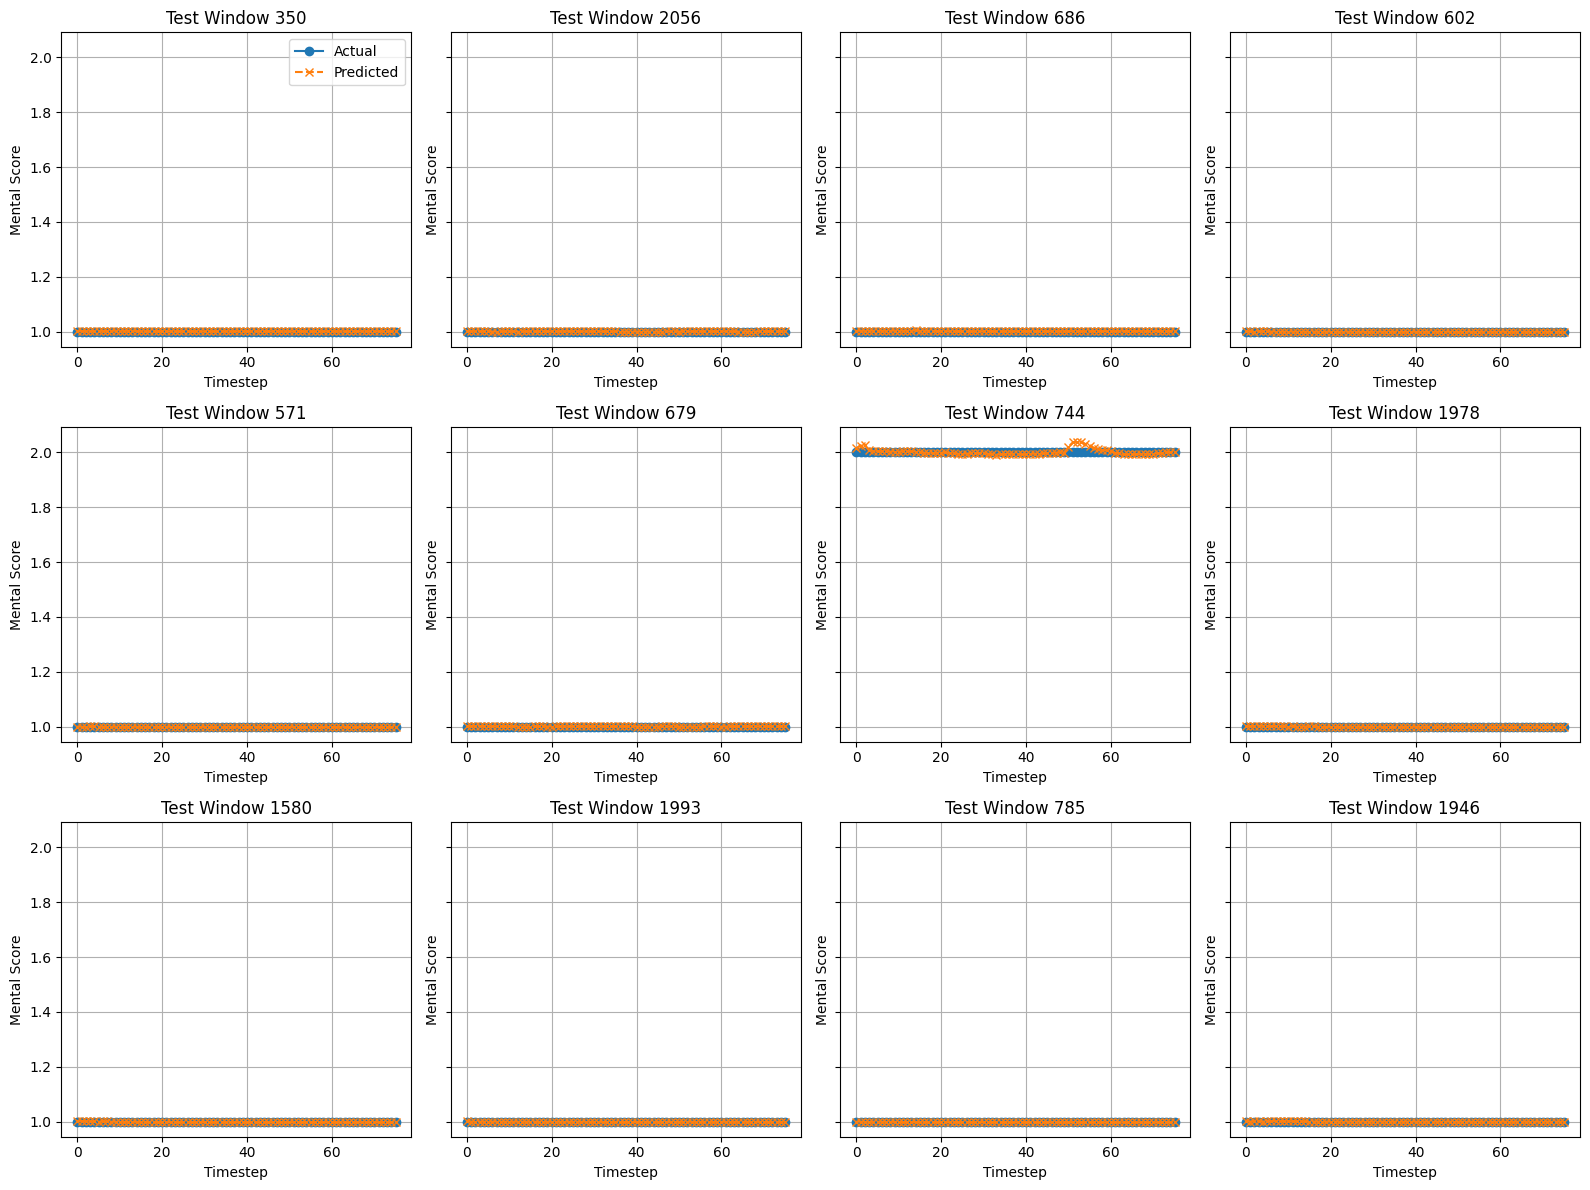

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

loss, mae = model.evaluate(
    X_test, y_test,
    sample_weight=sw_test
)
print("Test MSE:", loss, "Test MAE:", mae)

# Number of random test windows to plot
num_plots = 12
total_windows = X_test.shape[0]

# Randomly choose indices
np.random.seed(42)  # for reproducibility
indices = np.random.choice(total_windows, size=min(num_plots, total_windows), replace=False)

# Predict on the test set once
y_pred_all = model.predict(X_test)  # shape: (num_test_windows, T, 1)

# Grid dimensions (e.g., 3 rows x 4 cols)
cols = 4
rows = int(np.ceil(len(indices) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), sharey=True)
axes = axes.flatten()

for plot_idx, idx in enumerate(indices):
    ax = axes[plot_idx]
    real_len = int(np.sum(sw_test[idx] > 0))

    y_true = y_test[idx].squeeze()[:real_len]
    y_pred = y_pred_all[idx].squeeze()[:real_len]
    t = np.arange(real_len)

    ax.plot(t, y_true, marker='o', linestyle='-', label='Actual', linewidth=1.5)
    ax.plot(t, y_pred, marker='x', linestyle='--', label='Predicted', linewidth=1.5)
    ax.set_title(f"Test Window {idx}")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Mental Score")
    ax.grid(True)
    if plot_idx == 0:
        ax.legend(loc='upper right')

# Hide unused subplots
for i in range(len(indices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


fine tuned version

In [ ]:
model = tf.keras.models.load_model("/content/hopefully_final_Model.keras",
                                       custom_objects={'loss': directional_loss(lambda_delta=0.1)})

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


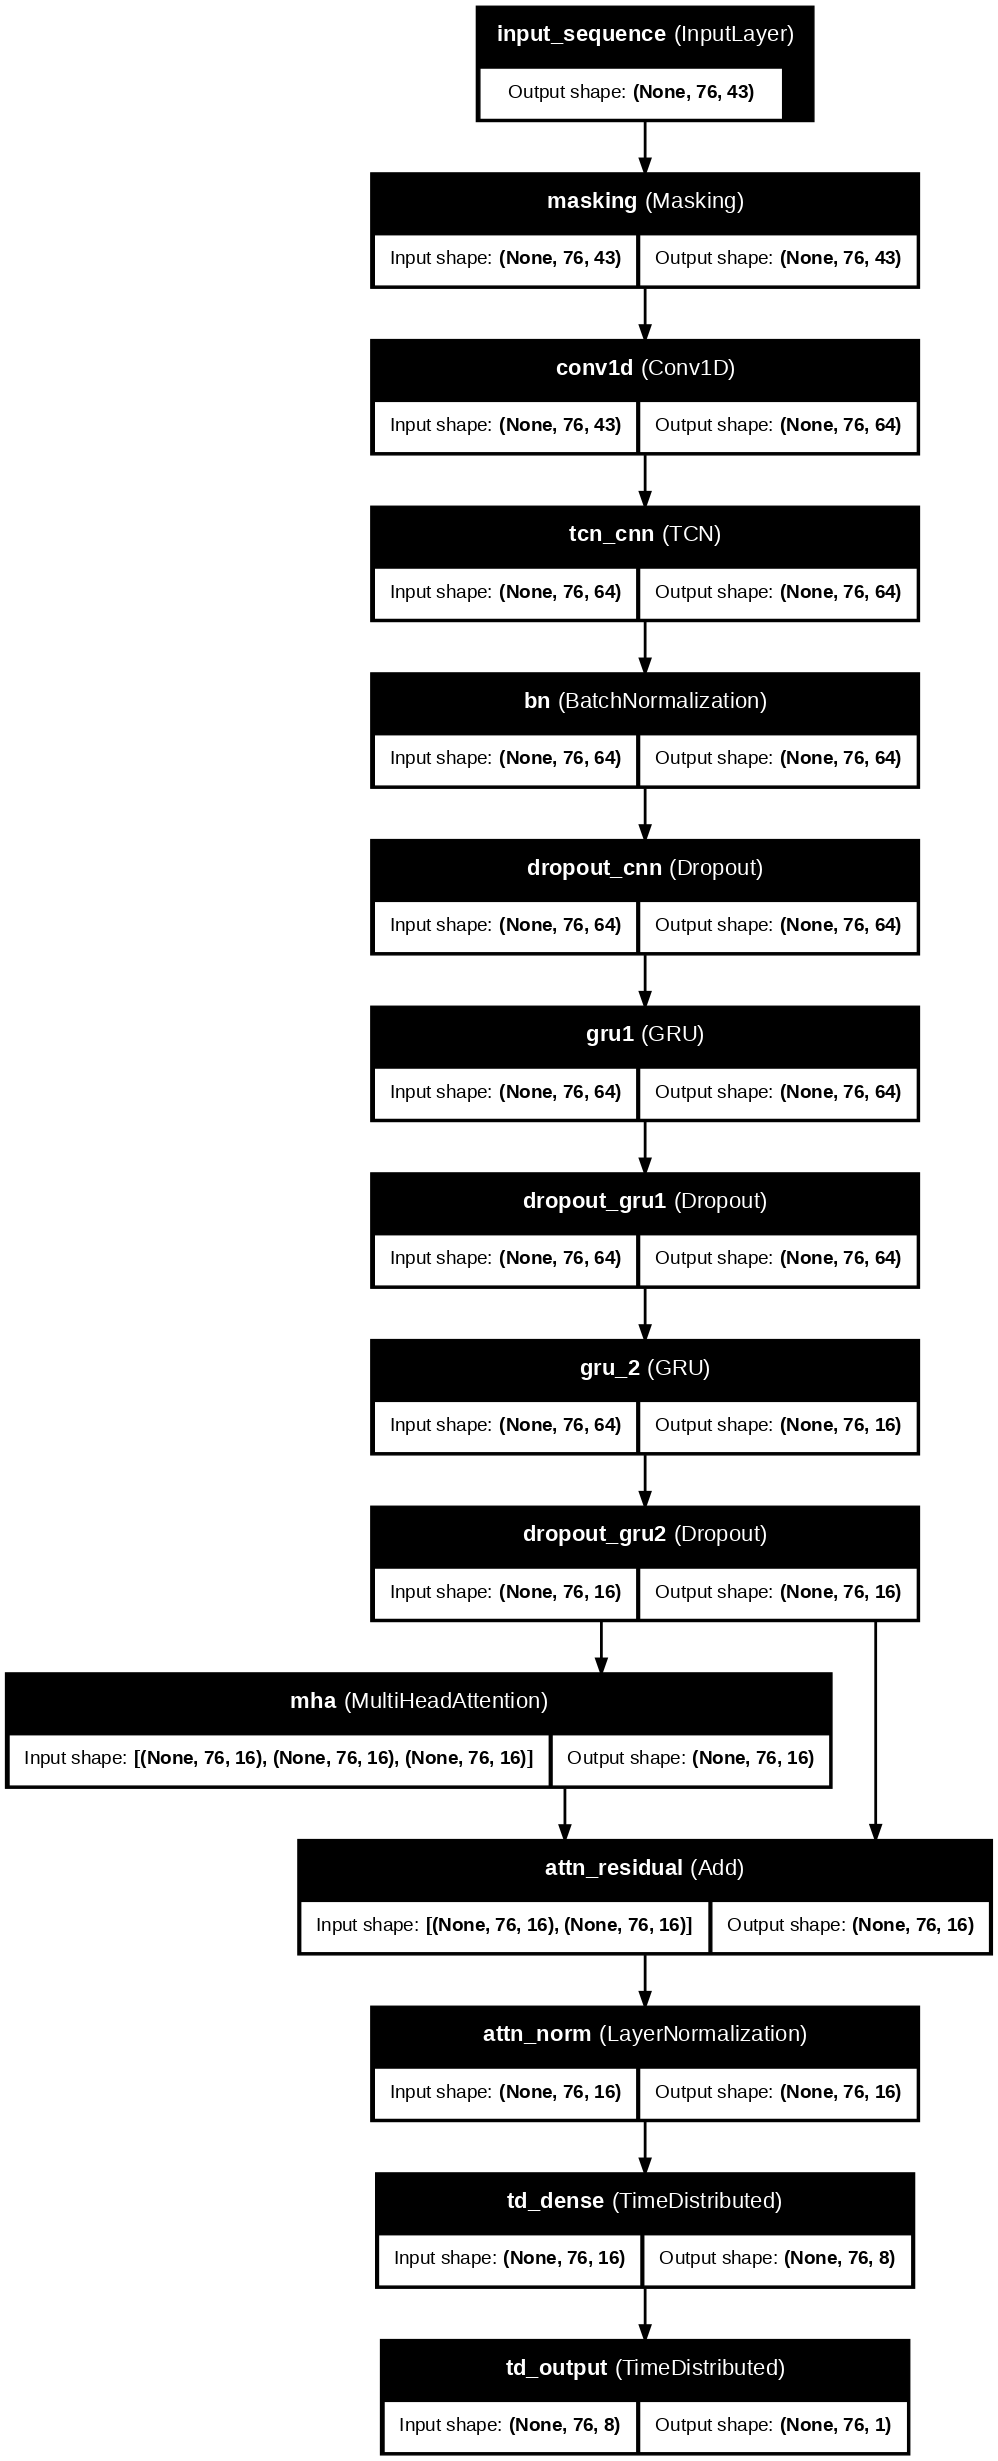

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file='model_baba.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=100
)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0957 - mae: 0.0711
Test MSE: 0.07913403958082199 Test MAE: 0.06034817546606064
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


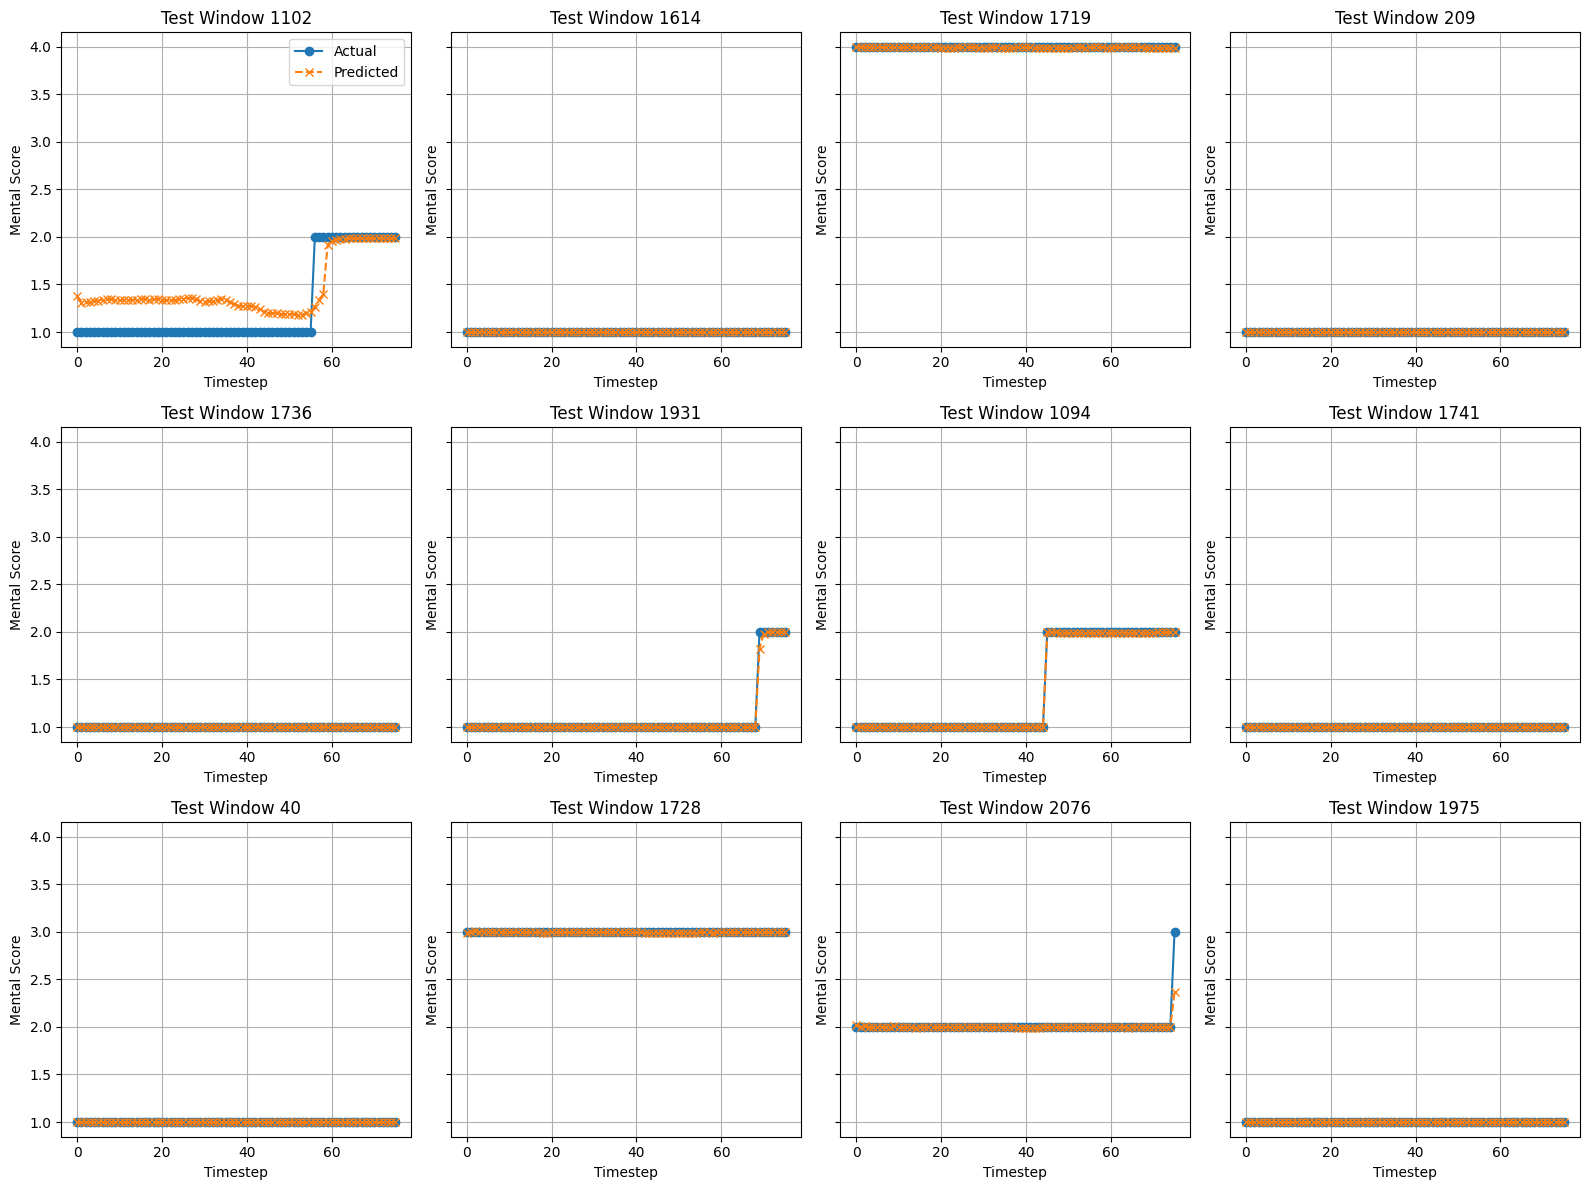

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

loss, mae = model.evaluate(
    X_test, y_test,
    sample_weight=sw_test
)
print("Test MSE:", loss, "Test MAE:", mae)

# Number of random test windows to plot
num_plots = 12
total_windows = X_test.shape[0]

# Randomly choose indices
np.random.seed(16)  # for reproducibility
indices = np.random.choice(total_windows, size=min(num_plots, total_windows), replace=False)

# Predict on the test set once
y_pred_all = model.predict(X_test)  # shape: (num_test_windows, T, 1)

# Grid dimensions (e.g., 3 rows x 4 cols)
cols = 4
rows = int(np.ceil(len(indices) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), sharey=True)
axes = axes.flatten()

for plot_idx, idx in enumerate(indices):
    ax = axes[plot_idx]
    real_len = int(np.sum(sw_test[idx] > 0))

    y_true = y_test[idx].squeeze()[:real_len]
    y_pred = y_pred_all[idx].squeeze()[:real_len]
    t = np.arange(real_len)

    ax.plot(t, y_true, marker='o', linestyle='-', label='Actual', linewidth=1.5)
    ax.plot(t, y_pred, marker='x', linestyle='--', label='Predicted', linewidth=1.5)
    ax.set_title(f"Test Window {idx}")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Mental Score")
    ax.grid(True)
    if plot_idx == 0:
        ax.legend(loc='upper right')

# Hide unused subplots
for i in range(len(indices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0013 - mae: 0.0058
Test MSE: 0.0012772909831255674 Test MAE: 0.005741269327700138
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


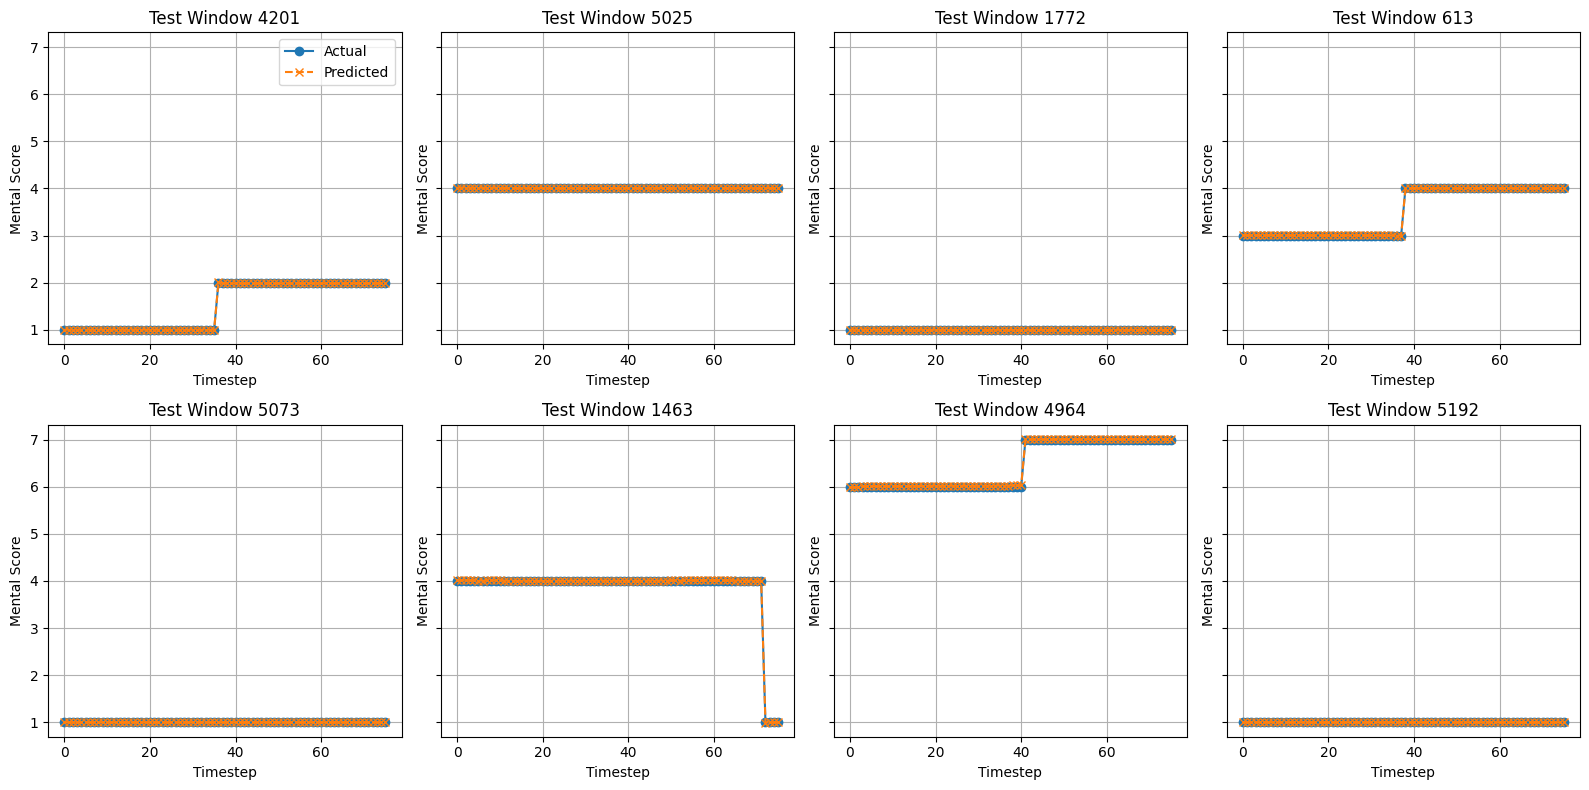

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

loss, mae = model.evaluate(
    X_test, y_test,
    sample_weight=sw_test
)
print("Test MSE:", loss, "Test MAE:", mae)

# Number of random test windows to plot
num_plots = 8
total_windows = X_test.shape[0]

# Randomly choose indices
np.random.seed(16)  # for reproducibility
indices = np.random.choice(total_windows, size=min(num_plots, total_windows), replace=False)

# Predict on the test set once
y_pred_all = model.predict(X_test)  # shape: (num_test_windows, T, 1)

# Grid dimensions (e.g., 3 rows x 4 cols)
cols = 4
rows = int(np.ceil(len(indices) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), sharey=True)
axes = axes.flatten()

for plot_idx, idx in enumerate(indices):
    ax = axes[plot_idx]
    real_len = int(np.sum(sw_test[idx] > 0))

    y_true = y_test[idx].squeeze()[:real_len]
    y_pred = y_pred_all[idx].squeeze()[:real_len]
    t = np.arange(real_len)

    ax.plot(t, y_true, marker='o', linestyle='-', label='Actual', linewidth=1.5)
    ax.plot(t, y_pred, marker='x', linestyle='--', label='Predicted', linewidth=1.5)
    ax.set_title(f"Test Window {idx}")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Mental Score")
    ax.grid(True)
    if plot_idx == 0:
        ax.legend(loc='upper right')

# Hide unused subplots
for i in range(len(indices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


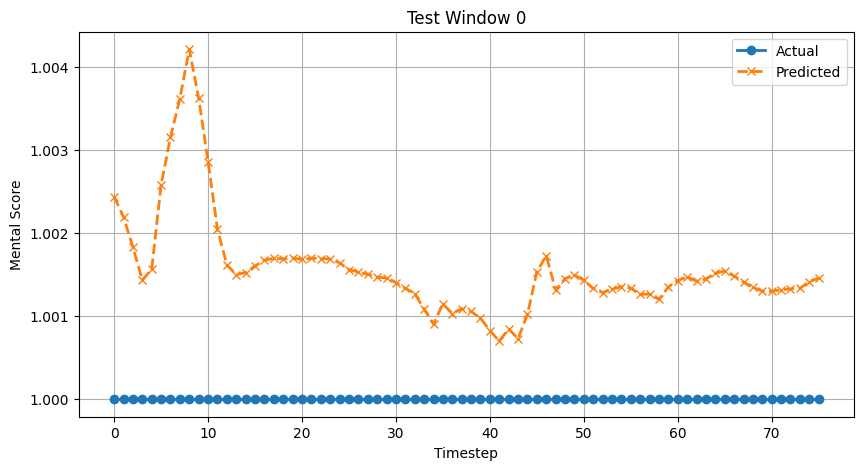

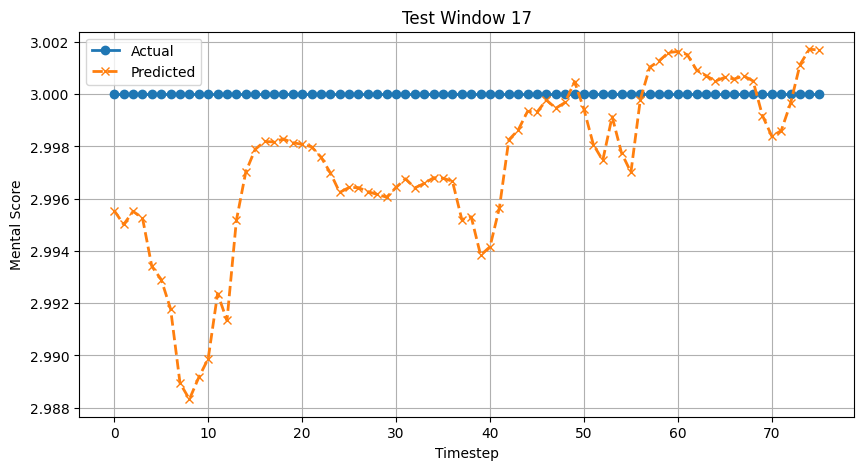

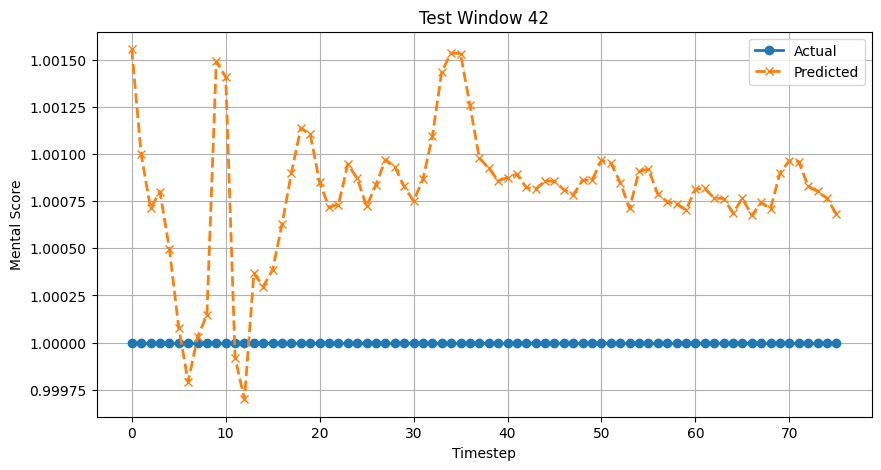

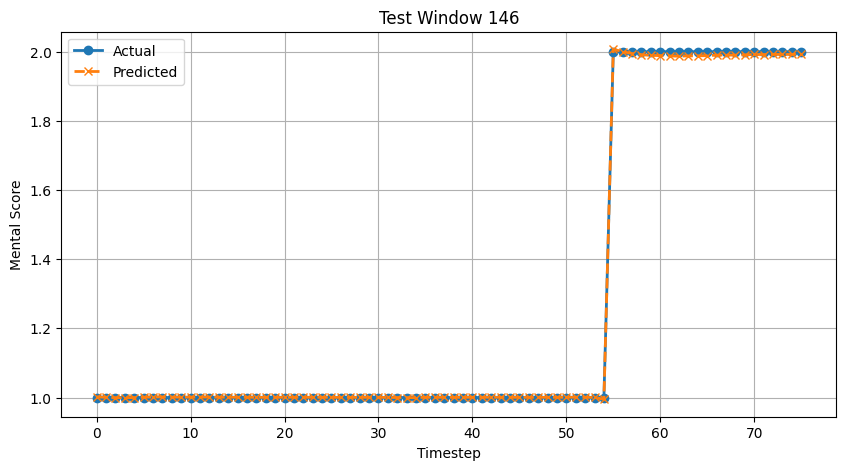

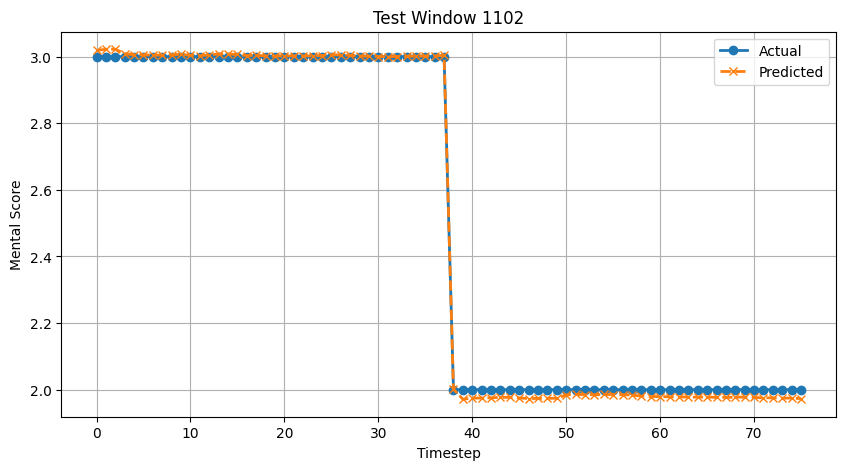

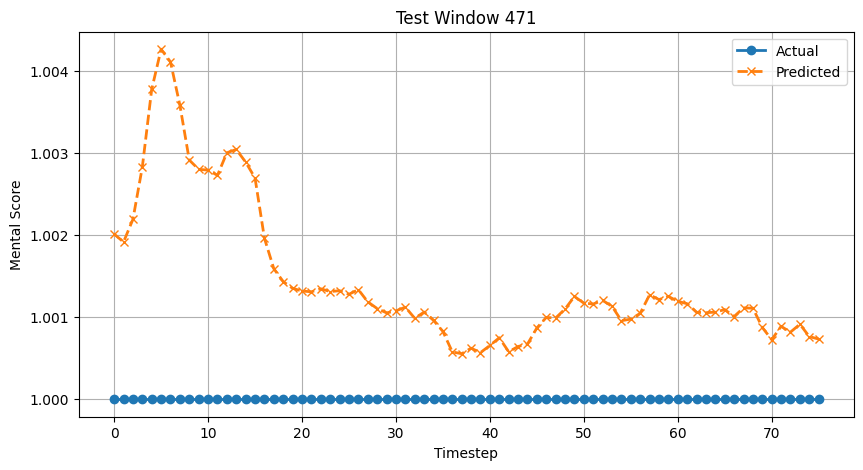

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Pre-compute predictions once and for all
y_pred_all = model.predict(X_test)  # shape (N_test, T, 1)

def plot_test_window(idx, X_test, y_test, sw_test, y_pred=y_pred_all):
    """
    Plot one test window idx using the same arrays everywhere.
    """
    # 1) Compute valid length
    valid = sw_test[idx] > 0
    real_len = int(np.sum(valid))

    # 2) Slice true & pred
    y_true = y_test[idx].squeeze()[:real_len]
    y_pr   = y_pred[idx].squeeze()[:real_len]
    t = np.arange(real_len)

    # 3) Plot
    plt.figure(figsize=(10, 5))
    plt.plot(t, y_true, 'o-', label='Actual', linewidth=2)
    plt.plot(t, y_pr,   'x--', label='Predicted', linewidth=2)
    plt.xlabel("Timestep")
    plt.ylabel("Mental Score")
    plt.title(f"Test Window {idx}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage examples:
plot_test_window(0, X_test, y_test, sw_test)
plot_test_window(17, X_test, y_test, sw_test)
plot_test_window(42, X_test, y_test, sw_test)
plot_test_window(146, X_test, y_test, sw_test)
plot_test_window(1102, X_test, y_test, sw_test)
plot_test_window(471, X_test, y_test, sw_test)


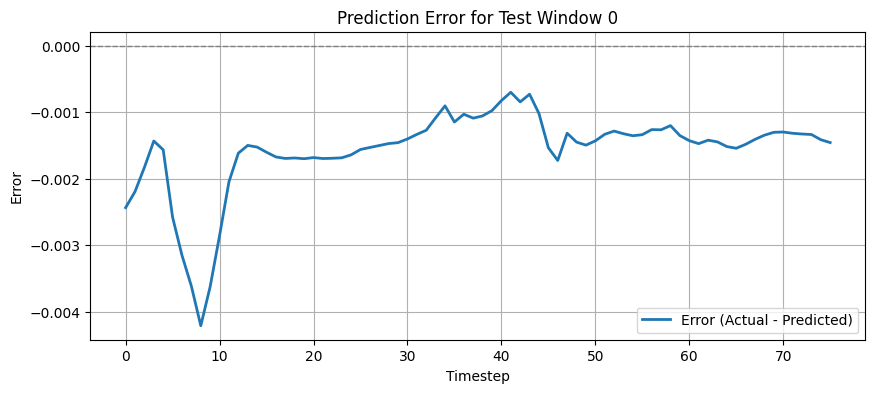

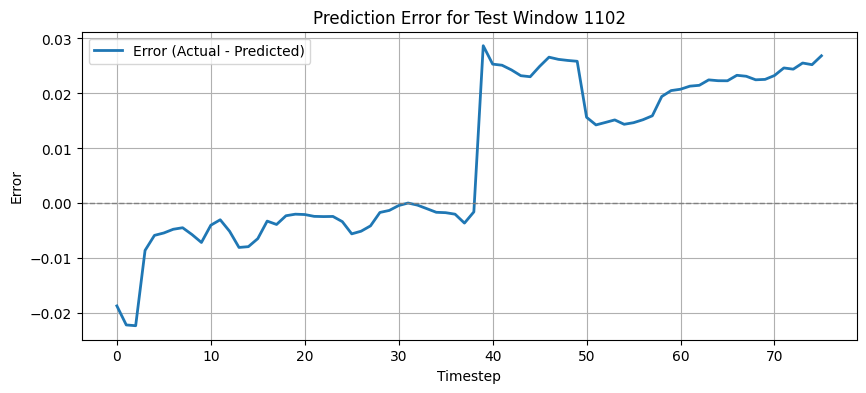

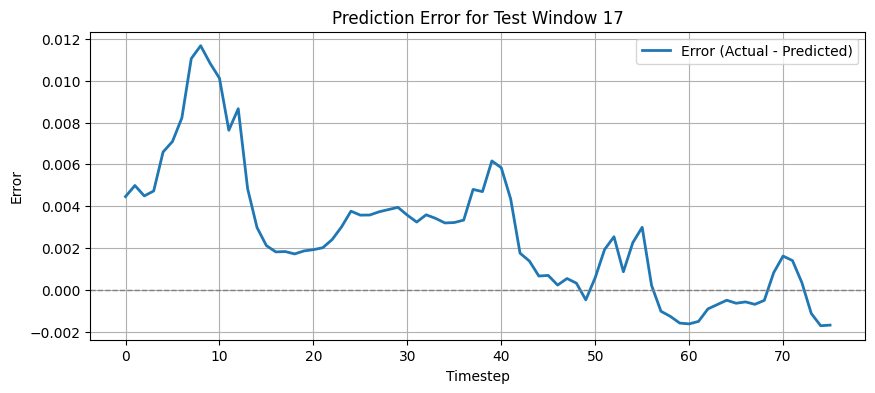

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_pred_all, X_test, y_test, and sw_test are defined as in previous cells

def plot_error_window(idx, y_test, sw_test, y_pred_all):
    """
    Plot the error (actual - predicted) for a single test window as a single line.

    Args:
        idx (int): Index of the test window to visualize.
        y_test (np.ndarray): Ground truth array, shape (N_test, T, 1).
        sw_test (np.ndarray): Sample weight mask, shape (N_test, T) or (N_test, T, 1).
        y_pred_all (np.ndarray): Predicted values, shape (N_test, T, 1).
    """
    # Ensure sw_test is 2D
    sw = sw_test.squeeze(-1) if sw_test.ndim == 3 else sw_test

    # Determine the valid length of this window
    real_len = int(np.sum(sw[idx] > 0))

    # Extract true and predicted values
    y_true = y_test[idx].squeeze()[:real_len]
    y_pr   = y_pred_all[idx].squeeze()[:real_len]

    # Compute error
    error = y_true - y_pr
    t = np.arange(real_len)

    # Plot error
    plt.figure(figsize=(10, 4))
    plt.plot(t, error, '-', linewidth=2, label='Error (Actual - Predicted)')
    plt.axhline(0, color='gray', linewidth=1, linestyle='--')
    plt.xlabel("Timestep")
    plt.ylabel("Error")
    plt.title(f"Prediction Error for Test Window {idx}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: plot error for window 0
plot_error_window(0, y_test, sw_test, y_pred_all)

# To plot error for another window, call:
plot_error_window(1102, y_test, sw_test, y_pred_all)
plot_error_window(17, y_test, sw_test, y_pred_all)


In [ ]:
import numpy as np

# Define the window indices you want to evaluate
window_indices = [17, 1102]

# Iterate through each selected window
for idx in window_indices:
    # Slice the test data for this specific window
    x_window = X_test[idx:idx+1]  # Shape: (1, 75, features)
    y_window = y_test[idx:idx+1]  # Shape: (1, 75)
    sw_window = sw_test[idx:idx+1]  # Shape: (1, 75)

    # Evaluate the model on this single window
    loss, mae = model.evaluate(
        x_window,
        y_window,
        sample_weight=sw_window,
        verbose=0
    )

    print(f"Window {idx} → MSE (loss): {loss:.8f}, MAE: {mae:.8f}")


Window 17 → MSE (loss): 0.00001709, MAE: 0.00311333
Window 1102 → MSE (loss): 0.00027007, MAE: 0.01321007


In [ ]:
model_baba.save("/content/hopefully_final_Model.keras")

In [ ]:
og_model = tf.keras.models.load_model("/content/VRCM_Net.keras",
                                       custom_objects={'loss': directional_loss(lambda_delta=0.1)})
og_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "cnn_bigru_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 76, 43)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 76, 43)    │          0 │ input_sequence[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 76, 64)    │      8,320 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_cnn (TCN)       │ (None, 76, 64)    │    123,520 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn                  │ (None, 76, 64)    │        256 │ tcn_cnn[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_cnn         │ (None, 76, 64)    │          0 │ bn[0][0]          │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru1 (GRU)          │ (None, 76, 64)    │     24,960 │ dropout_cnn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_gru1        │ (None, 76, 64)    │          0 │ gru1[0][0]        │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 76, 16)    │      3,936 │ dropout_gru1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_gru2        │ (None, 76, 16)    │          0 │ gru_2[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 76, 16)    │      6,448 │ dropout_gru2[0][… │
│ (MultiHeadAttentio… │                   │            │ dropout_gru2[0][… │
│                     │                   │            │ dropout_gru2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_residual (Add) │ (None, 76, 16)    │          0 │ dropout_gru2[0][… │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_norm           │ (None, 76, 16)    │         32 │ attn_residual[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense            │ (None, 76, 8)     │        136 │ attn_norm[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_output           │ (None, 76, 1)     │          9 │ td_dense[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 502,597 (1.92 MB)

 Trainable params: 167,489 (654.25 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 334,980 (1.28 MB)

In [ ]:
print(model.input_shape)
# e.g. (None, 76, 10)  ← so T=76, D=10


(None, 76, 10)


#### Testing

In [ ]:
enriched_dim = X_train.shape[2]   # e.g. 10


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, MaxPooling1D, GRU, Dropout, TimeDistributed, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# 1) Custom directional loss
def directional_loss(lambda_delta=0.1):
    def loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        dy_true = y_true[:, 1:, :] - y_true[:, :-1, :]
        dy_pred = y_pred[:, 1:, :] - y_pred[:, :-1, :]
        mse_delta = tf.reduce_mean(tf.square(dy_true - dy_pred))
        return mse_loss + lambda_delta * mse_delta
    return loss

# 2) Model builder
def build_model(hp):
    filters   = hp.Choice('filters',    [16, 32, 64])
    kernel    = hp.Choice('kernel',     [2, 3, 5])
    units1    = hp.Choice('gru1',       [32, 64, 128])
    units2    = hp.Choice('gru2',       [16, 32, 64])
    dropout1  = hp.Float('drop1',       0.1, 0.3, step=0.1)
    dropout2  = hp.Float('drop2',       0.05, 0.2, step=0.05)
    lr        = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    inp = Input(shape=(max_sequence_length, enriched_dim))
    x   = Masking(mask_value=0.0)(inp)
    x   = Conv1D(filters, kernel, padding='same', activation='relu')(x)
    x   = MaxPooling1D(2, strides=1, padding='same')(x)
    x   = GRU(units1, return_sequences=True, dropout=dropout1)(x)
    x   = GRU(units2, return_sequences=True, dropout=dropout2)(x)
    x   = TimeDistributed(Dense(16, activation='relu'))(x)
    out = TimeDistributed(Dense(1, activation='linear'))(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=directional_loss(lambda_delta=0.1),  # your custom transition‐aware loss
        metrics=['mae']
    )
    return model


# 3) Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cybersickness_tuning'
)

# 4) Run search
tuner.search(
    X_train,
    y_train,
    sample_weight=weights_train.squeeze(-1),
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# 5) Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(f"  filters:       {best_hps.get('filters')}")
print(f"  kernel size:   {best_hps.get('kernel')}")
print(f"  GRU units1:    {best_hps.get('gru1')}")
print(f"  GRU units2:    {best_hps.get('gru2')}")
print(f"  dropout1:      {best_hps.get('drop1')}")
print(f"  dropout2:      {best_hps.get('drop2')}")
print(f"  learning rate: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 01m 11s]
val_mae: 1.0314371585845947

Best val_mae So Far: 0.8912538290023804
Total elapsed time: 00h 08m 24s
Best hyperparameters:
  filters:       16
  kernel size:   2
  GRU units1:    32
  GRU units2:    16
  dropout1:      0.1
  dropout2:      0.1
  learning rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Testing v2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, MaxPooling1D, GRU, Dropout, TimeDistributed, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
enriched_dim = X_combined.shape[2]

# 2) Model builder
def build_model(hp):
    filters   = hp.Choice('filters',    [16, 32, 64])
    kernel    = hp.Choice('kernel',     [2, 3, 5])
    units1    = hp.Choice('gru1',       [32, 64, 128])
    units2    = hp.Choice('gru2',       [16, 32, 64])
    dropout1  = hp.Float('drop1',       0.1, 0.3, step=0.1)
    dropout2  = hp.Float('drop2',       0.05, 0.2, step=0.05)
    lr        = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    inp = Input(shape=(max_sequence_length, enriched_dim))
    x   = Masking(mask_value=0.0)(inp)
    x   = Conv1D(filters, kernel, padding='same', activation='relu')(x)
    x   = MaxPooling1D(2, strides=1, padding='same')(x)
    x   = GRU(units1, return_sequences=True, dropout=dropout1)(x)
    x   = GRU(units2, return_sequences=True, dropout=dropout2)(x)
    x   = TimeDistributed(Dense(16, activation='relu'))(x)
    out = TimeDistributed(Dense(1, activation='linear'))(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=directional_loss(lambda_delta=0.1),  # your custom transition‐aware loss
        metrics=['mae']
    )
    return model


# 3) Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cybersickness_tuning',
    overwrite=True
)

# 4) Run search
tuner.search(
    X_combined,
    y_combined,
    sample_weight=weights_combined.squeeze(-1),
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# 5) Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(f"  filters:       {best_hps.get('filters')}")
print(f"  kernel size:   {best_hps.get('kernel')}")
print(f"  GRU units1:    {best_hps.get('gru1')}")
print(f"  GRU units2:    {best_hps.get('gru2')}")
print(f"  dropout1:      {best_hps.get('drop1')}")
print(f"  dropout2:      {best_hps.get('drop2')}")
print(f"  learning rate: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 00m 14s]
val_mae: 0.07562536746263504

Best val_mae So Far: 0.027855264022946358
Total elapsed time: 00h 02m 32s
Best hyperparameters:
  filters:       16
  kernel size:   2
  GRU units1:    64
  GRU units2:    32
  dropout1:      0.2
  dropout2:      0.1
  learning rate: 0.0001


## Testing

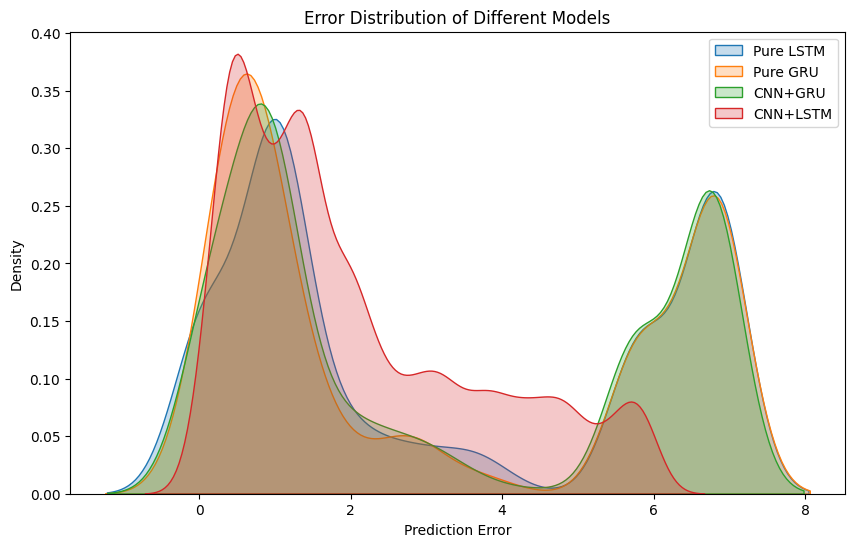

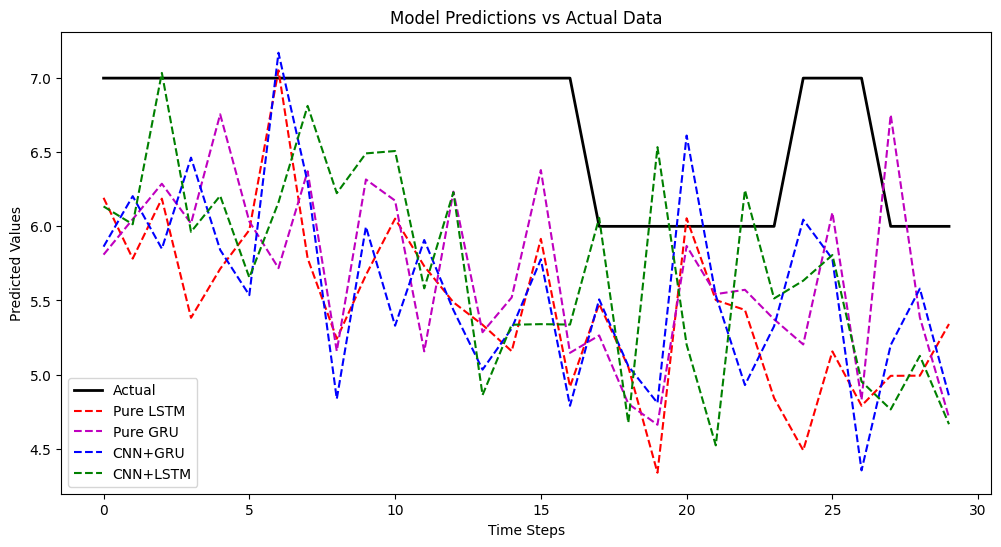

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Fix KDE plot warning ---
plt.figure(figsize=(10,6))
sns.kdeplot(error_pure_lstm.flatten(), label="Pure LSTM", fill=True)
sns.kdeplot(error_pure_gru.flatten(), label="Pure GRU", fill=True)
sns.kdeplot(error_cnn_gru.flatten(), label="CNN+GRU", fill=True)
sns.kdeplot(error_cnn_lstm.flatten(), label="CNN+LSTM", fill=True)

plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.title("Error Distribution of Different Models")
plt.legend()
plt.show()

# --- Fix time series plot ---
plt.figure(figsize=(12, 6))

# Ensure y_true_example and y_pred have the same length as timesteps
T = min(len(y_true_example), len(y_pred_example_pure_lstm))  # Adjust T dynamically
timesteps = np.arange(T)

plt.plot(timesteps, y_true_example[:T], 'k-', label="Actual", linewidth=2)
plt.plot(timesteps, y_pred_example_pure_lstm[:T], 'r--', label="Pure LSTM")
plt.plot(timesteps, y_pred_example_pure_gru[:T], 'm--', label="Pure GRU")
plt.plot(timesteps, y_pred_example_cnn_gru[:T], 'b--', label="CNN+GRU")
plt.plot(timesteps, y_pred_example_cnn_lstm[:T], 'g--', label="CNN+LSTM")

plt.xlabel("Time Steps")
plt.ylabel("Predicted Values")
plt.title("Model Predictions vs Actual Data")
plt.legend()
plt.show()
